In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
# Device configuration
device = "mps"  # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_dim = 2
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
# VAE model without reparameterization trick
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def sample_z(self, mu, logvar):
        # Sample z ~ N(mu, sigma^2)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        # Do not use reparameterization trick; directly sample z
        z = (
            mu + std * eps.detach()
        )  # Detach to prevent backpropagation through sampling
        return z

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        out = self.sigmoid(self.fc4(h3))
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_recon, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_recon, x.view(-1, 28 * 28), reduction="sum"
    )
    # KL divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [4]:
# Training the VAE
model.train()
train_losses = []
for epoch in range(1, num_epochs + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1, 28 * 28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    average_loss = train_loss / len(train_loader.dataset)
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, average_loss))
    train_losses.append(average_loss)


====> Epoch: 1 Average loss: 191.7228
====> Epoch: 2 Average loss: 168.5035
====> Epoch: 3 Average loss: 164.1250
====> Epoch: 4 Average loss: 161.8460
====> Epoch: 5 Average loss: 160.1401
====> Epoch: 6 Average loss: 158.8039
====> Epoch: 7 Average loss: 157.7314
====> Epoch: 8 Average loss: 156.6904
====> Epoch: 9 Average loss: 155.8872
====> Epoch: 10 Average loss: 155.1504


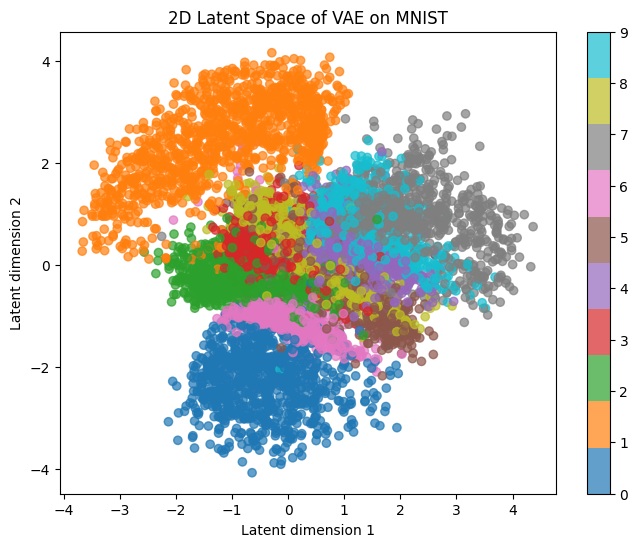

In [5]:
# Plotting the 2D latent space
model.eval()
with torch.no_grad():
    z_list = []
    labels_list = []
    for i, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        data = data.view(-1, 28 * 28)
        mu, logvar = model.encode(data)
        z = mu
        z_list.append(z)
        labels_list.append(labels)

    z_all = torch.cat(z_list)
    labels_all = torch.cat(labels_list)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        z_all[:, 0].cpu(),
        z_all[:, 1].cpu(),
        c=labels_all.cpu(),
        cmap="tab10",
        alpha=0.7,
    )
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.title("2D Latent Space of VAE on MNIST")
    plt.show()

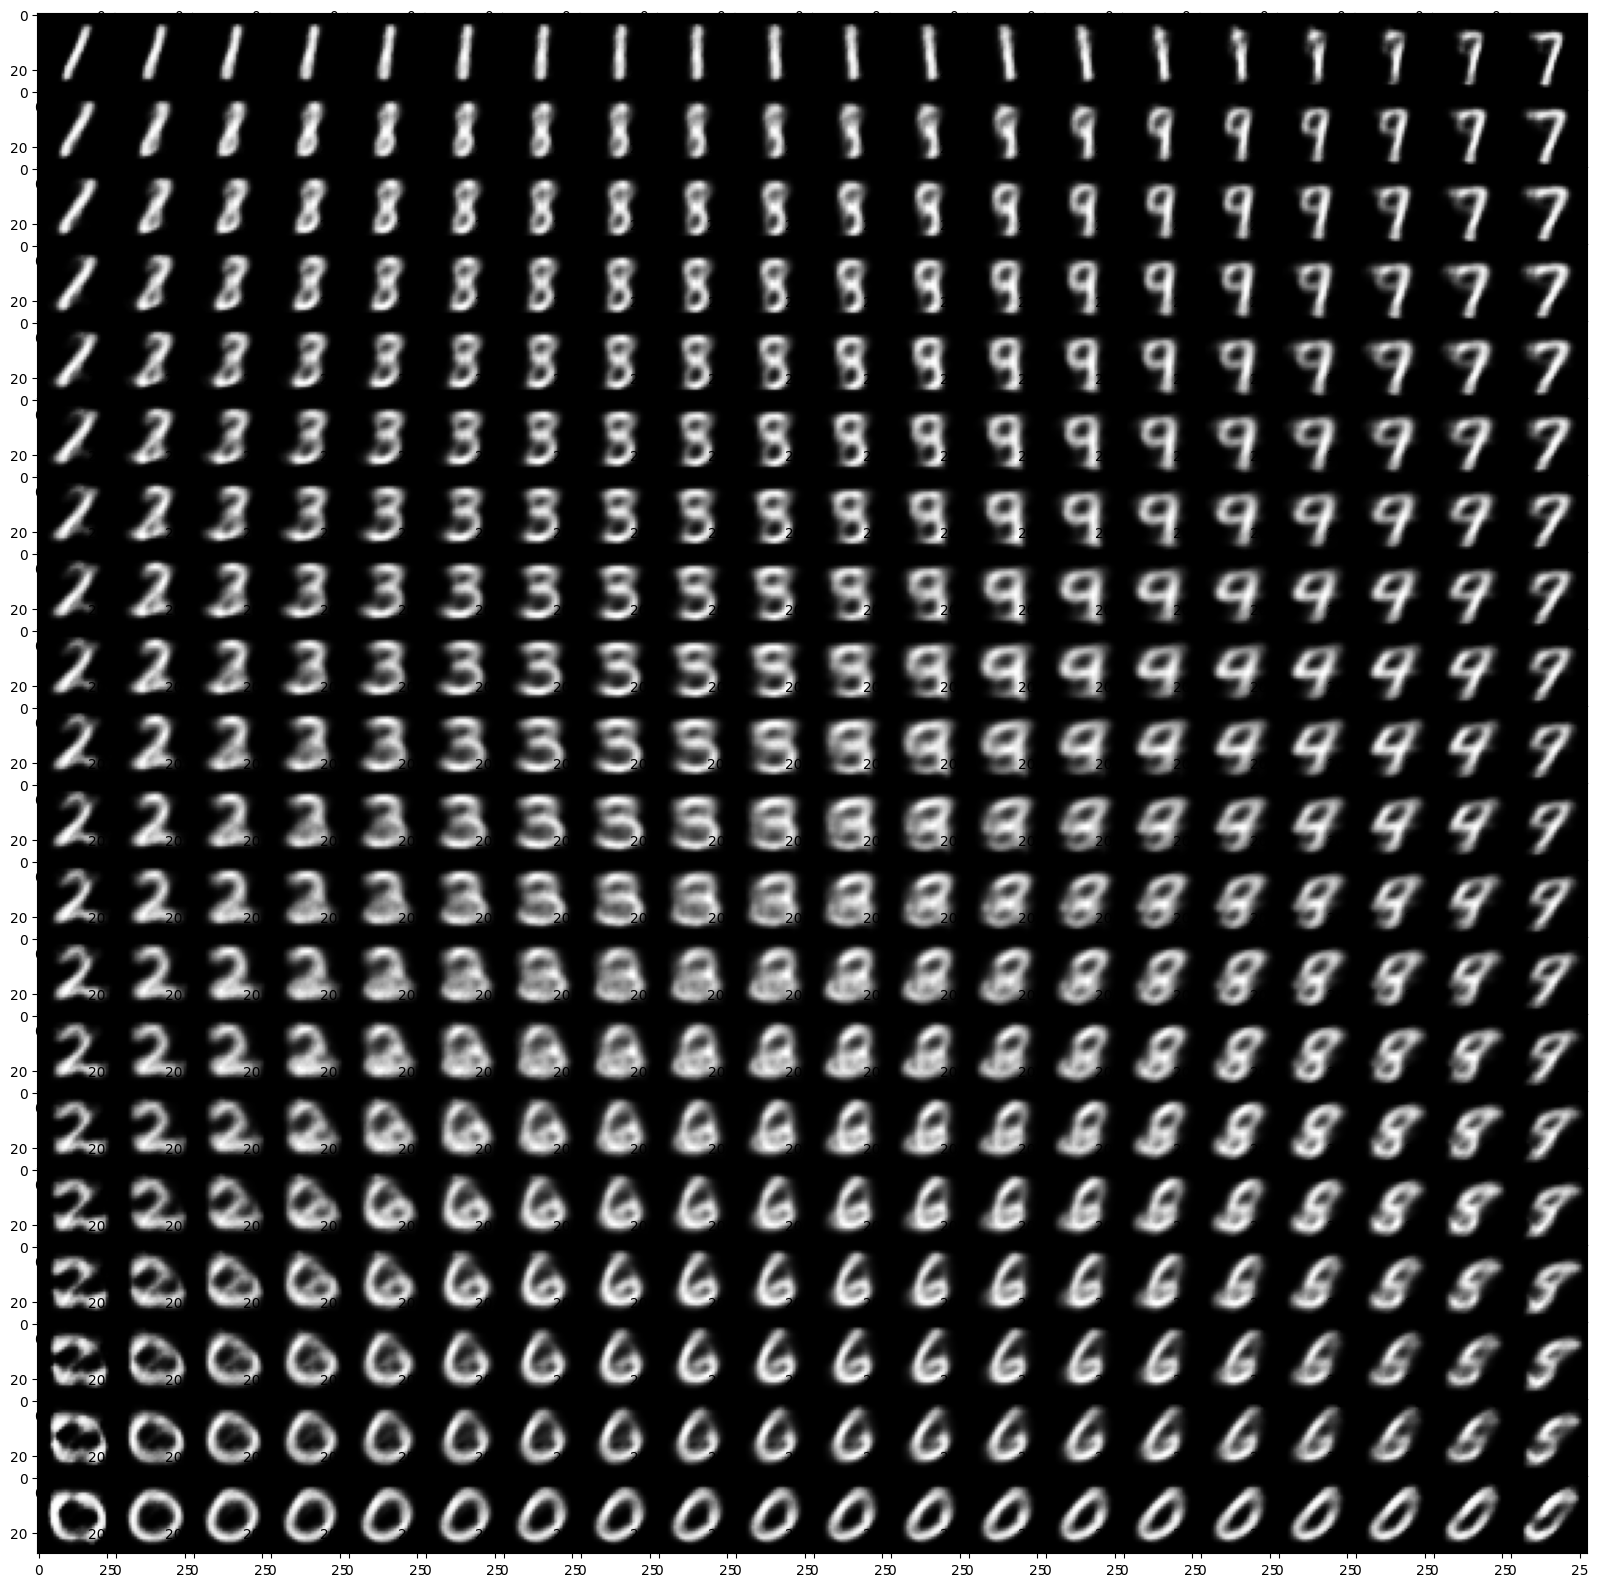

In [6]:
# Define the grid size
k = 20  # Number of points along each dimension

grid_x = torch.linspace(0.01, 0.99, k)
grid_y = torch.linspace(0.01, 0.99, k)
mesh_x, mesh_y = torch.meshgrid(
    grid_x, grid_y, indexing="xy"
)  # Ensure correct axis indexing

# Stack the grid coordinates into a shape (k*k, 2)
coords = torch.stack([mesh_x, mesh_y], dim=-1).view(-1, 2)

# Map the uniformly distributed samples to the standard normal distribution using the inverse CDF
normal = torch.distributions.normal.Normal(0, 1)
z = normal.icdf(coords)  # Shape: (k*k, 2)

# Ensure the model is in evaluation mode
model.eval()

# Move the grid points to the same device as the model
z = z.to(device)

with torch.no_grad():
    # Decode the latent variables to generate images
    reconstructed = model.decode(z).cpu()  # Shape: (k*k, 28*28)

# Reshape the reconstructed images for visualization
images = reconstructed.view(-1, 1, 28, 28)  # Shape: (k*k, 1, 28, 28)

# Convert images to NumPy array for plotting
images = images.numpy()

# Create a figure with a grid of subplots
fig, axes = plt.subplots(k, k, figsize=(k, k))

for i in range(k):
    for j in range(k):
        idx = i * k + j  # Index of the current image
        # Reverse the order of rows to have the lowest latent y-values at the bottom
        ax = axes[k - i - 1, j]
        ax.imshow(images[idx, 0, :, :], cmap="gray")
        # ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

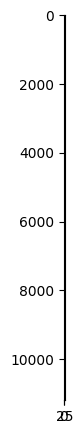

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(np.block(list(map(list, images))), cmap="gray")
plt.show()